In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import csv 

from matplotlib.ticker import StrMethodFormatter

%matplotlib inline

In [3]:
games_df = pd.read_csv('./points_data/charting-m-matches.csv', encoding='windows-1252',quoting=csv.QUOTE_NONE)
points_df = pd.read_csv('./points_data/charting-m-points-2020s.csv', encoding='windows-1252')

points_df = pd.merge(points_df, games_df[['match_id', 'Player 1', 'Player 2', 'Date', 'Surface']], on='match_id', how='left')
points_df['Date'] = pd.to_datetime(points_df['Date'], format='%Y%m%d')

def get_svr_ret(row):
    if row['Svr'] == 1:
        row['Svr'] = row['Player 1']
        row['Ret'] = row['Player 2']
    else:
        row['Svr'] = row['Player 2']
        row['Ret'] = row['Player 1']
    return row

points_df = points_df.apply(get_svr_ret, axis=1)
#points_df = points_df.head(10000)
points_df.head()

/var/folders/lx/p5r75k3x27xclt9brw3142bw0000gn/T/ipykernel_15137/1666505994.py:2: DtypeWarning: Columns (8,9,29) have mixed types. Specify dtype option on import or set low_memory=False.
  points_df = pd.read_csv('./points_data/charting-m-points-2020s.csv', encoding='windows-1252')


,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,...,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Player 1,Player 2,Date,Surface
0,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,1,0,0,0,0,0-0,1 (1),1,0,...,True,False,False,1,1,1,Novak Djokovic,Ben Shelton,2023-09-08,Hard
1,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0,0,15-0,1 (2),1,0,...,False,False,False,2,0,8,Novak Djokovic,Ben Shelton,2023-09-08,Hard
2,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,3,0,0,0,0,15-15,1 (3),1,0,...,False,False,False,2,0,4,Novak Djokovic,Ben Shelton,2023-09-08,Hard
3,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,4,0,0,0,0,15-30,1 (4),1,0,...,False,False,False,1,1,3,Novak Djokovic,Ben Shelton,2023-09-08,Hard
4,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,5,0,0,0,0,30-30,1 (5),1,0,...,False,False,False,1,1,3,Novak Djokovic,Ben Shelton,2023-09-08,Hard


In [4]:
points_df = points_df.replace(r"^ +| +$", r"", regex=True)
points_df['Surface'].replace(['Hard Indoor', 'Indoor Hard'], 'Hard', inplace=True)
serve_grouped_df = points_df.groupby(['Svr', 'Ret', 'Surface']).aggregate({'PtWinner':'count', 
                                                                          'isSvrWinner':'sum'}).reset_index()

serve_grouped_df

,Svr,Ret,Surface,PtWinner,isSvrWinner
0,Abedallah Shelbayh,Soon Woo Kwon,Hard,87,55
1,Abedallah Shelbayh,Thanasi Kokkinakis,Hard,63,34
2,Adrian Andreev,Corentin Moutet,Hard,127,76
3,Adrian Mannarino,Alex De Minaur,Hard,123,70
4,Adrian Mannarino,Alex Michelsen,Grass,49,36
...,...,...,...,...,...
2475,Zhizhen Zhang,Jan Lennard Struff,Grass,53,27
2476,Zhizhen Zhang,Tim Van Rijthoven,Hard,157,106
2477,Zizou Bergs,Gregoire Barrere,Hard,78,49
2478,Zizou Bergs,Thanasi Kokkinakis,Hard,94,64


In [5]:
plt.rcParams["figure.constrained_layout.use"] = True
svr, players = pd.factorize(serve_grouped_df["Svr"], sort=True)
ret, _ = pd.factorize(serve_grouped_df["Ret"], sort=True)
sur, surface_unique = pd.factorize(serve_grouped_df["Surface"], sort=True)
coords = {"player": players, "surface": surface_unique}
count = serve_grouped_df['PtWinner']
serve_won = serve_grouped_df['isSvrWinner']

In [6]:
beta_params = pm.find_constrained_prior(pm.Beta, lower = 0.50, upper = 0.78,
                          init_guess={'alpha':6,'beta':3.8 })
beta_params

/Users/davidfrid/miniconda3/envs/pymc_env/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/davidfrid/miniconda3/envs/pymc_env/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/davidfrid/miniconda3/envs/pymc_env/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/davidfrid/miniconda3/envs/pymc_env/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op betainc does not

{'alpha': 28.04814598125381, 'beta': 15.262344048681378}

In [7]:
with pm.Model(coords=coords) as tennis_binomial_model:
    server = pm.MutableData('server', svr)
    returner = pm.MutableData('returner', ret)
    surface = pm.MutableData('surface', sur)
    
    #global parameters
    sd_att = pm.HalfNormal("sd_svr", sigma=1)
    sd_def = pm.HalfNormal("sd_ret", sigma=1)
    sur_sd = pm.HalfNormal('sur_sd', sigma=1)
    p = pm.Beta("p", **beta_params)

    #surface parameters
    sur_delt = pm.Normal('sur_delt', mu=0, sigma=sur_sd, dims='surface')

    #player ability paramters
    svr_star = pm.Normal("svr_star", mu=0, sigma=sd_att, dims="player")
    ret_star = pm.Normal("ret_star", mu=0, sigma=sd_def, dims="player")
    atts = pm.Deterministic("atts", svr_star - pt.mean(svr_star), dims="player")
    defs = pm.Deterministic("defs", ret_star - pt.mean(ret_star), dims="player")

    theta = pm.Deterministic('theta', pm.math.invlogit(p + sur_delt[surface] + atts[server] + defs[returner]))

    y = pm.Binomial('y', n=count, p=theta, observed=serve_won)
    trace = pm.sample(1000, tune=1500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_svr, sd_ret, sur_sd, p, sur_delt, svr_star, ret_star]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 34 seconds.


array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

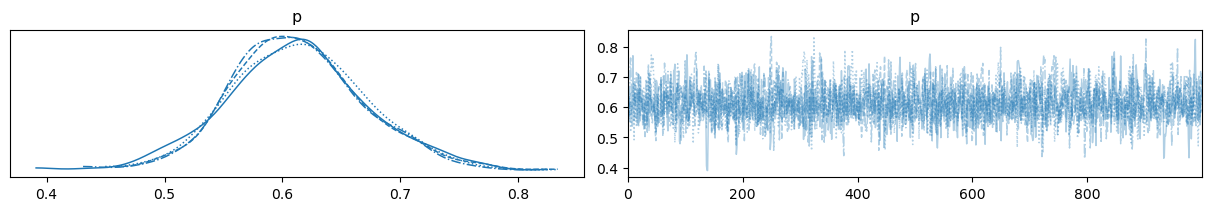

In [66]:
az.plot_trace(trace,var_names=['p'])

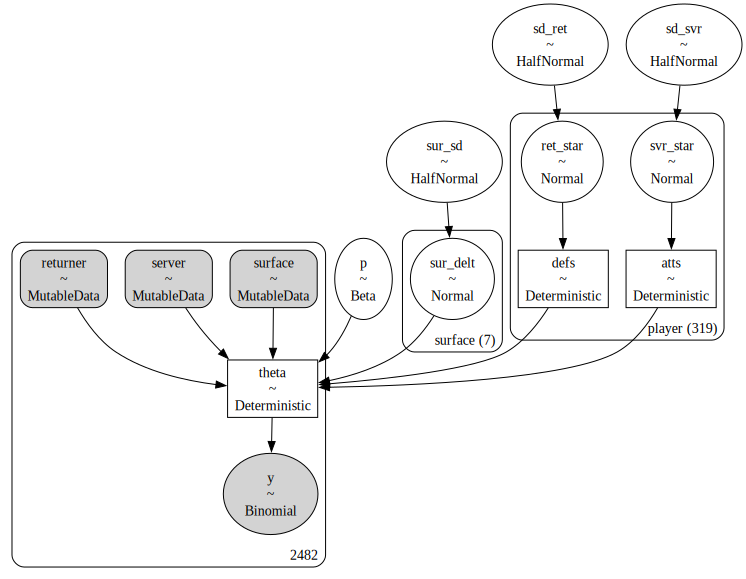

In [47]:
tennis_binomial_model.to_graphviz()

Sampling: [y]


/Users/davidfrid/miniconda3/envs/pymc_env/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


<Axes: xlabel='y / y'>

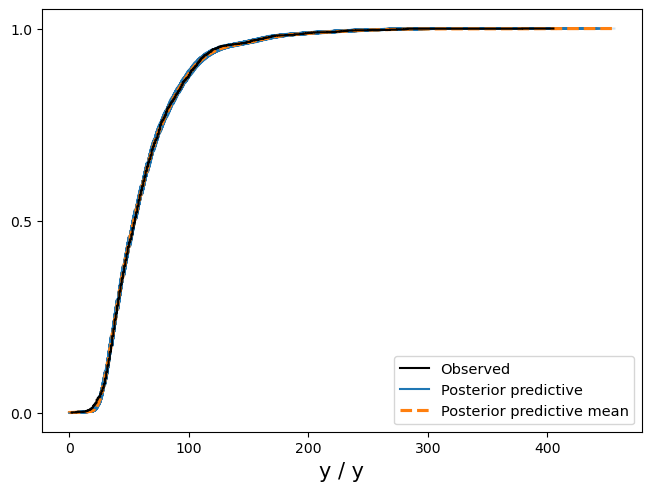

In [59]:
with tennis_binomial_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
az.plot_ppc(trace, kind='cumulative')

In [61]:
az.summary(trace).to_csv('serve_return_binomial.csv')

Sigmoid.0

In [9]:
points_df.sort_values('Date')

,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,...,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Player 1,Player 2,Date,Surface
246781,20200103-M-ATP_Cup-RR-Alex_De_Minaur-Alexander...,207,1,1,5,2,40-30,31 (6),1.0,0,...,True,False,False,1,1,11,Alex De Minaur,Alexander Zverev,2020-01-03,Hard
246380,20200103-M-ATP_Cup-RR-Steve_Darcis-Alexander_C...,204,1,1,4,3,15-0,31 (2),1.0,0,...,True,False,False,1,1,1,Steve Darcis,Alexander Cozbinov,2020-01-03,Hard
246379,20200103-M-ATP_Cup-RR-Steve_Darcis-Alexander_C...,203,1,1,4,3,0-0,31 (1),1.0,0,...,True,False,False,1,1,3,Steve Darcis,Alexander Cozbinov,2020-01-03,Hard
246378,20200103-M-ATP_Cup-RR-Steve_Darcis-Alexander_C...,202,1,1,4,2,AD-40,30 (14),1.0,0,...,False,True,False,2,1,5,Steve Darcis,Alexander Cozbinov,2020-01-03,Hard
246377,20200103-M-ATP_Cup-RR-Steve_Darcis-Alexander_C...,201,1,1,4,2,40-40,30 (13),1.0,0,...,True,False,False,2,1,3,Steve Darcis,Alexander Cozbinov,2020-01-03,Hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,130,2,0,2,1,40-30,21 (6),1,0,...,False,False,False,2,0,6,Novak Djokovic,Ben Shelton,2023-09-08,Hard
128,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,129,2,0,2,1,30-30,21 (5),1,0,...,False,False,False,1,1,5,Novak Djokovic,Ben Shelton,2023-09-08,Hard
127,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,128,2,0,2,1,15-30,21 (4),1,0,...,True,False,False,1,1,5,Novak Djokovic,Ben Shelton,2023-09-08,Hard
137,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,138,2,0,3,1,40-30,22 (6),1,0,...,False,False,False,1,0,6,Novak Djokovic,Ben Shelton,2023-09-08,Hard
